# ***ML Training***

In [ ]:
!pip install xgboost lightgbm tensorflow scikit-learn

In [ ]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

from sklearn.preprocessing import StandardScaler
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score
from sklearn.ensemble import RandomForestRegressor
from xgboost import XGBRegressor
from lightgbm import LGBMRegressor

from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import LSTM, Dense, Dropout
from tensorflow.keras.callbacks import EarlyStopping

In [ ]:
df = pd.read_csv("/content/bitcoin.csv")
df['Date'] = pd.to_datetime(df['Date'])
df = df.sort_values('Date')
df.reset_index(drop=True, inplace=True)

df.head()

,Date,Open,High,Low,Close,Adj Close,Volume
0,2017-01-01,963.66,1003.08,958.70,998.33,998.33,147775008
1,2017-01-02,998.62,1031.39,996.70,1021.75,1021.75,222184992
2,2017-01-03,1021.60,1044.08,1021.60,1043.84,1043.84,185168000
3,2017-01-04,1044.40,1159.42,1044.40,1154.73,1154.73,344945984
4,2017-01-05,1156.73,1191.10,910.42,1013.38,1013.38,510199008


In [ ]:
features = ['Open', 'High', 'Low', 'Adj Close', 'Volume']
target = 'Close'

X = df[features]
y = df[target]

In [ ]:
split = int(len(df) * 0.8)

X_train = X.iloc[:split]
X_test = X.iloc[split:]
y_train = y.iloc[:split]
y_test = y.iloc[split:]

scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)

In [ ]:
rf = RandomForestRegressor(n_estimators=300, random_state=42)
rf.fit(X_train_scaled, y_train)
rf_pred = rf.predict(X_test_scaled)

In [ ]:
xgb = XGBRegressor(
    n_estimators=400,
    learning_rate=0.05,
    max_depth=6,
    random_state=42
)
xgb.fit(X_train_scaled, y_train)
xgb_pred = xgb.predict(X_test_scaled)

In [ ]:
lgbm = LGBMRegressor(
    n_estimators=400,
    learning_rate=0.05,
    random_state=42
)
lgbm.fit(X_train_scaled, y_train)
lgbm_pred = lgbm.predict(X_test_scaled)

[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000116 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 1275
[LightGBM] [Info] Number of data points in the train set: 839, number of used features: 5
[LightGBM] [Info] Start training from score 5559.779345
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain,

/usr/local/lib/python3.12/dist-packages/sklearn/utils/validation.py:2739: UserWarning: X does not have valid feature names, but LGBMRegressor was fitted with feature names
  warnings.warn(


In [ ]:
from sklearn.preprocessing import MinMaxScaler

# Scale features
feature_scaler = MinMaxScaler()
X_scaled = feature_scaler.fit_transform(X)

# Scale target
target_scaler = MinMaxScaler()
y_scaled = target_scaler.fit_transform(y.values.reshape(-1, 1))

In [ ]:
def create_lstm_sequences(X, y, time_steps=20):
    Xs, ys = [], []
    for i in range(time_steps, len(X)):
        Xs.append(X[i-time_steps:i])
        ys.append(y[i])
    return np.array(Xs), np.array(ys)

TIME_STEPS = 20

X_lstm, y_lstm = create_lstm_sequences(X_scaled, y_scaled, TIME_STEPS)

split = int(len(X_lstm) * 0.8)

X_train_lstm = X_lstm[:split]
X_test_lstm = X_lstm[split:]
y_train_lstm = y_lstm[:split]
y_test_lstm = y_lstm[split:]

In [ ]:
from tensorflow.keras.optimizers import Adam

model = Sequential([
    LSTM(128, return_sequences=True, input_shape=(TIME_STEPS, X_train_lstm.shape[2])),
    Dropout(0.3),
    LSTM(64),
    Dropout(0.3),
    Dense(1)
])

model.compile(
    optimizer=Adam(learning_rate=0.001),
    loss='mse'
)

es = EarlyStopping(
    monitor='val_loss',
    patience=10,
    restore_best_weights=True
)

model.fit(
    X_train_lstm,
    y_train_lstm,
    epochs=60,
    batch_size=32,
    validation_split=0.1,
    callbacks=[es],
    verbose=1
)

Epoch 1/60


/usr/local/lib/python3.12/dist-packages/keras/src/layers/rnn/rnn.py:199: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


24/24 ━━━━━━━━━━━━━━━━━━━━ 6s 56ms/step - loss: 0.0383 - val_loss: 0.0031
Epoch 2/60
24/24 ━━━━━━━━━━━━━━━━━━━━ 1s 47ms/step - loss: 0.0053 - val_loss: 1.7022e-04
Epoch 3/60
24/24 ━━━━━━━━━━━━━━━━━━━━ 2s 67ms/step - loss: 0.0031 - val_loss: 1.1693e-04
Epoch 4/60
24/24 ━━━━━━━━━━━━━━━━━━━━ 1s 43ms/step - loss: 0.0031 - val_loss: 1.7195e-04
Epoch 5/60
24/24 ━━━━━━━━━━━━━━━━━━━━ 1s 38ms/step - loss: 0.0037 - val_loss: 3.5932e-04
Epoch 6/60
24/24 ━━━━━━━━━━━━━━━━━━━━ 1s 38ms/step - loss: 0.0031 - val_loss: 1.2976e-04
Epoch 7/60
24/24 ━━━━━━━━━━━━━━━━━━━━ 1s 39ms/step - loss: 0.0032 - val_loss: 2.4899e-04
Epoch 8/60
24/24 ━━━━━━━━━━━━━━━━━━━━ 1s 38ms/step - loss: 0.0029 - val_loss: 1.2753e-04
Epoch 9/60
24/24 ━━━━━━━━━━━━━━━━━━━━ 1s 37ms/step - loss: 0.0024 - val_loss: 7.9216e-04
Epoch 10/60
24/24 ━━━━━━━━━━━━━━━━━━━━ 1s 37ms/step - loss: 0.0024 - val_loss: 1.2058e-04
Epoch 11/60
24/24 ━━━━━━━━━━━━━━━━━━━━ 1s 37ms/step - loss: 0.0025 - val_loss: 0.0010
Epoch 12/60
24/24 ━━━━━━━━━━━━━━━━━━━━

In [ ]:
# Predict (scaled)
lstm_pred_scaled = model.predict(X_test_lstm)

# Inverse scale predictions and true values
lstm_pred = target_scaler.inverse_transform(lstm_pred_scaled).flatten()
y_test_lstm_true = target_scaler.inverse_transform(y_test_lstm).flatten()

7/7 ━━━━━━━━━━━━━━━━━━━━ 1s 64ms/step


In [ ]:
evaluate(y_test_lstm_true, lstm_pred, "LSTM (Correctly Trained)")

LSTM (Correctly Trained)
RMSE: 599.3834794178844
MAE : 438.327134310528
R²  : 0.8684198039131472
------------------------------


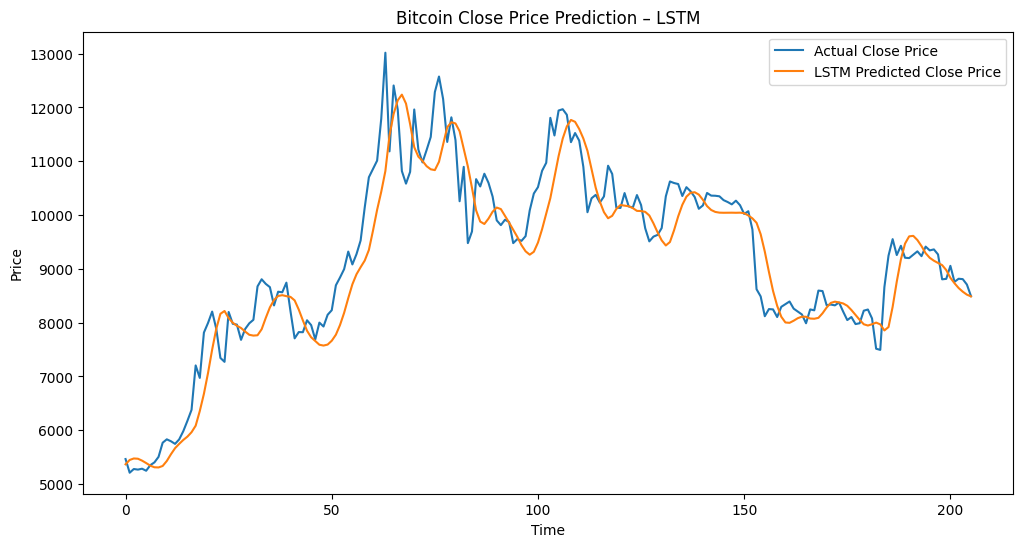

In [ ]:
plt.figure(figsize=(12,6))
plt.plot(y_test_lstm_true, label="Actual Close Price")
plt.plot(lstm_pred, label="LSTM Predicted Close Price")
plt.title("Bitcoin Close Price Prediction – LSTM")
plt.xlabel("Time")
plt.ylabel("Price")
plt.legend()
plt.show()

In [ ]:
evaluate(y_test, rf_pred, "Random Forest")
evaluate(y_test, xgb_pred, "XGBoost")
evaluate(y_test, lgbm_pred, "LightGBM")
evaluate(y_test_lstm_true, lstm_pred, "LSTM (Correctly Trained)")

Random Forest
RMSE: 68.40828014340622
MAE : 30.422510158728862
R²  : 0.9984131776712066
------------------------------
XGBoost
RMSE: 118.42333679005695
MAE : 61.834357142857144
R²  : 0.9952446164953136
------------------------------
LightGBM
RMSE: 147.55786858803637
MAE : 87.3199281165734
R²  : 0.9926169517629628
------------------------------
LSTM (Correctly Trained)
RMSE: 599.3834794178844
MAE : 438.327134310528
R²  : 0.8684198039131472
------------------------------


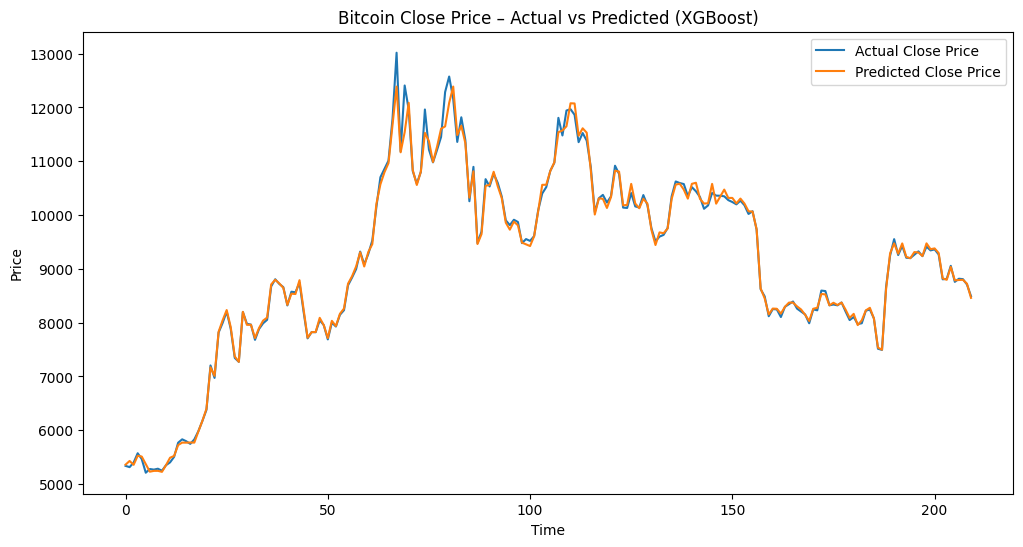

In [ ]:
plt.figure(figsize=(12,6))
plt.plot(y_test.values, label="Actual Close Price")
plt.plot(xgb_pred, label="Predicted Close Price")
plt.title("Bitcoin Close Price – Actual vs Predicted (XGBoost)")
plt.xlabel("Time")
plt.ylabel("Price")
plt.legend()
plt.show()

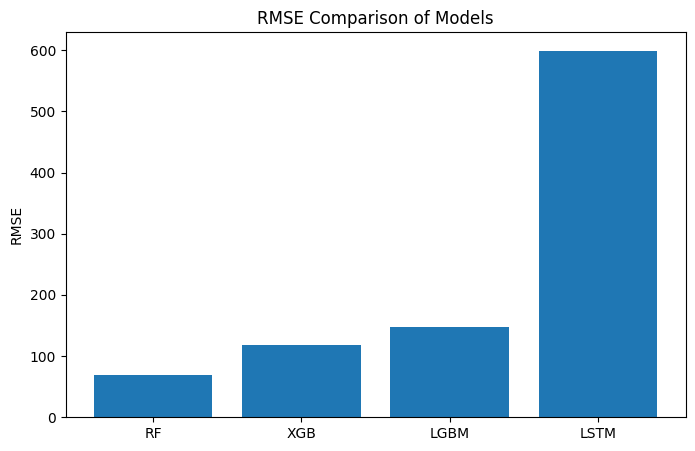

In [ ]:
models = ['RF', 'XGB', 'LGBM', 'LSTM']
rmse_values = [
    np.sqrt(mean_squared_error(y_test, rf_pred)),
    np.sqrt(mean_squared_error(y_test, xgb_pred)),
    np.sqrt(mean_squared_error(y_test, lgbm_pred)),
    np.sqrt(mean_squared_error(y_test_lstm_true, lstm_pred))
]

plt.figure(figsize=(8,5))
plt.bar(models, rmse_values)
plt.title("RMSE Comparison of Models")
plt.ylabel("RMSE")
plt.show()

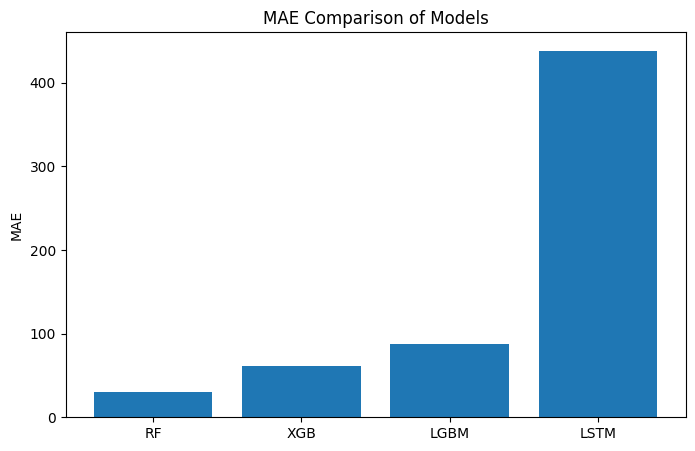

In [ ]:
models = ['RF', 'XGB', 'LGBM', 'LSTM']

mae_values = [
    mean_absolute_error(y_test, rf_pred),
    mean_absolute_error(y_test, xgb_pred),
    mean_absolute_error(y_test, lgbm_pred),
    mean_absolute_error(y_test_lstm_true, lstm_pred)
]

plt.figure(figsize=(8,5))
plt.bar(models, mae_values)
plt.title("MAE Comparison of Models")
plt.ylabel("MAE")
plt.show()

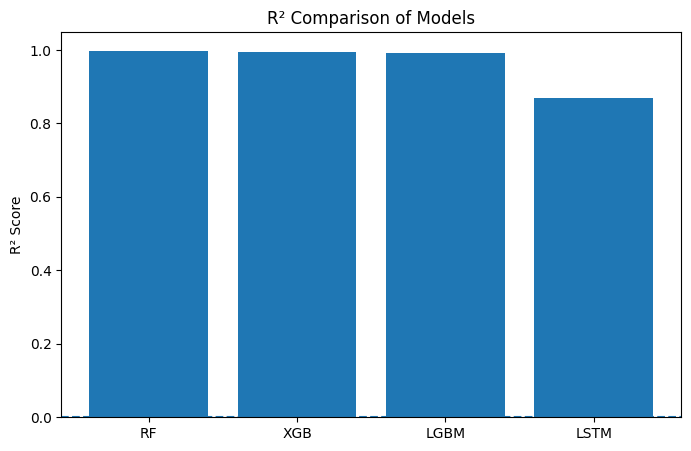

In [ ]:
r2_values = [
    r2_score(y_test, rf_pred),
    r2_score(y_test, xgb_pred),
    r2_score(y_test, lgbm_pred),
    r2_score(y_test_lstm_true, lstm_pred)
]

plt.figure(figsize=(8,5))
plt.bar(models, r2_values)
plt.title("R² Comparison of Models")
plt.ylabel("R² Score")
plt.axhline(0, linestyle='--')  # reference line
plt.show()